In [0]:
!pip install tensorflow==2.0.0-beta

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, utils, Model
from tensorflow.keras import layers, utils, Model
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [5]:
class GoogleNet():

    def __init__(self, kernel_initializer, kernel_regularizer, gamma_initializer, dropout, epsilon, weight_decay, momentum):

        self.kernel_regularizer = kernel_regularizer
        self.kernel_initializer = kernel_initializer
        self.gamma_initializer = gamma_initializer
        self.dropout = dropout
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.momentum = momentum
    
    def auxiliary_block(self, x, name):
      
        avg_pool = AveragePooling2D((5, 5), strides=3)(x)
        cnv = Conv2D(128, (1,1), padding='same', activation='relu')(avg_pool)
        flt = Flatten()(cnv)
        dense = Dense(1024, activation='relu')(flt)
        dense_drpt = Dropout(self.dropout)(dense)  
        auxiliary_out = Dense(10, activation='softmax', name='auxiliary_out'+name)(dense_drpt)

        return auxiliary_out


    def inception_block(self, x, f_1x1, f_3x3_red, f_3x3, f_5x5_red, f_5x5, f_pool, name):

        conv1_1x1 = Conv2D(f_1x1, (1,1), padding='same', kernel_regularizer=l2(self.kernel_regularizer), name=name+"_conv1_1x1")(x)
        conv2_3x3_red = Conv2D(f_3x3_red, (1, 1), padding='same', kernel_regularizer=l2(self.kernel_regularizer), name=name+"_conv2_3x3_red")(conv1_1x1)
        conv2_3x3 = Conv2D(f_3x3, (3,3), padding='same', kernel_regularizer=l2(self.kernel_regularizer), name=name+"_conv2_3x3")(conv2_3x3_red)
        conv2_5x5_red = Conv2D(f_5x5_red, (1, 1), padding='same', kernel_regularizer=l2(self.kernel_regularizer), name=name+"_conv2_5x5_red")(conv2_3x3)
        conv2_5x5 = Conv2D(f_5x5, (5,5), padding='same', kernel_regularizer=l2(self.kernel_regularizer), name=name+"_conv2_5x5")(conv2_5x5_red)
        max_pool = MaxPool2D((3, 3), strides=(1, 1), padding='same')(conv2_5x5)
        conv_1x1 = Conv2D(f_pool, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(self.kernel_regularizer), name=name+"_conv_1x1")(max_pool)

        output = concatenate([conv1_1x1, conv2_3x3, conv2_5x5, conv_1x1], axis=3, name=name)
    
        return output


    def build_model(self, input_dim):
         
        conv1_7x7 = Conv2D(filters=64, kernel_size=(7, 7), padding='same', strides = (2,2), activation="relu", name='conv1_7x7')(input_dim)
        max_pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", name='max_pool_1')(conv1_7x7)
        inc_lrn_1 = tf.nn.local_response_normalization(max_pool_1, name="inc_lrn_1")

        conv_2a_3x3 = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3')(inc_lrn_1)
        conv2_3x3 = Conv2D(192, (3,3), padding='same', name='conv_2b_3x3', kernel_regularizer=l2(self.kernel_regularizer), strides = 1, use_bias=False)(conv_2a_3x3)
        max_pool_2 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", name='max_pool_2')(conv2_3x3)

        inception_3a = self.inception_block(max_pool_2, f_1x1=64, f_3x3_red=96, f_3x3=128, f_5x5_red=16, f_5x5=32, f_pool=32, name='incept_3a')
        inception_3b = self.inception_block(inception_3a, f_1x1=128, f_3x3_red=128, f_3x3=192, f_5x5_red=32, f_5x5=96, f_pool=64, name='incept_3b')
        max_pool_3 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", name='max_pool_3')(inception_3b)

        inception_4a = self.inception_block(max_pool_3, f_1x1=192, f_3x3_red=96, f_3x3=208, f_5x5_red=16, f_5x5=48, f_pool=64, name='incept_4a')
        aux_4a = self.auxiliary_block(inception_4a,"_4a")
        inception_4b = self.inception_block(inception_4a, f_1x1=160, f_3x3_red=112, f_3x3=224, f_5x5_red=24, f_5x5=64, f_pool=64, name='incept_4b')
        inception_4c = self.inception_block(inception_4b, f_1x1=128, f_3x3_red=128, f_3x3=256, f_5x5_red=24, f_5x5=64, f_pool=64, name='incept_4c')
        inception_4d = self.inception_block(inception_4c, f_1x1=112, f_3x3_red=144, f_3x3=288, f_5x5_red=32, f_5x5=64, f_pool=64, name='incept_4d')
        aux_4d = self.auxiliary_block(inception_4d,"_4d")
        inception_4e = self.inception_block(inception_4d, f_1x1=256, f_3x3_red=160, f_3x3=320, f_5x5_red=32, f_5x5=128, f_pool=128, name='incept_4e')

        max_pool_4 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", name='max_pool_4')(inception_4e)
        inception_5a = self.inception_block(max_pool_4, f_1x1=256, f_3x3_red=160, f_3x3=320, f_5x5_red=32, f_5x5=128, f_pool=128, name='incept_5a')
        inception_5b = self.inception_block(inception_5a, f_1x1=384, f_3x3_red=192, f_3x3=384, f_5x5_red=48, f_5x5=128, f_pool=128, name='incept_5b')

        avg_pool = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding="valid", name="avg_pool_1")(inception_5b)
        dropout = Dropout((0.4))(avg_pool)
        linear = Dense(1000, activation='softmax')(dropout)
        
        model = Model(inputs, linear)
        return model


if __name__ == "__main__":
    gnet = GoogleNet('he_normal', 0.0002, 'uniform', 0.7, 1e-5, 0.0005, 0.1)
    input = (224, 224, 3)
    inputs = Input(shape=input, name='input_layer')
    gn = gnet.build_model(inputs)

    gn.summary()
    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_7x7 (Conv2D)              (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
max_pool_1 (MaxPooling2D)       (None, 56, 56, 64)   0           conv1_7x7[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_inc_lrn_1_1 (Tensor [(None, 56, 56, 64)] 0           max_pool_1[0][0]                 
____________________________________________________________________________________________

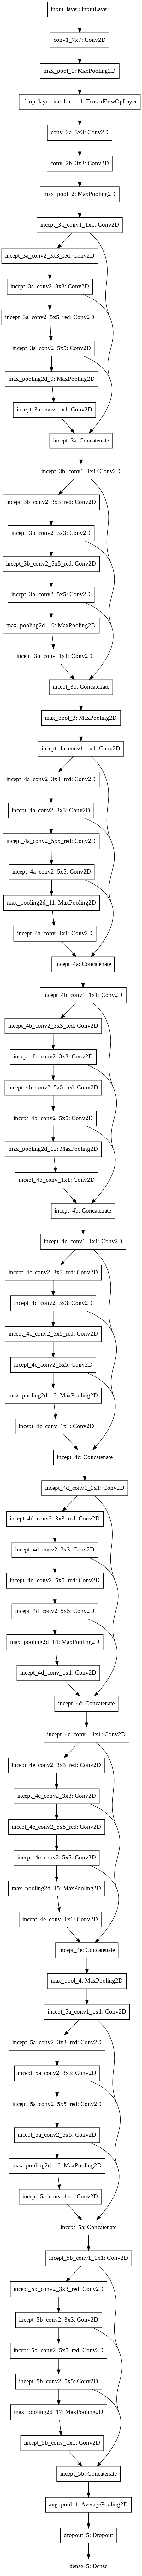

In [6]:
utils.plot_model(gn)